# Capstone Project - The Battle of Neighborhoods (Week 2)

## Applied Data Science Capstone IBM Coursera

### Introduction and Business Problem

The goal of this project is finding the safest London's borough based on the total crimes and exploring that borough's neighborhoods for finding the 10 most common venues for every nighborhood, then clustering the neighborhoos by using k-mean clustering.

This project is for someone who want to imigrate to London. Therefor the most imporatnt concern for who are looking to relocate to a new place is safty. Because if people do not feel safe in their property they would not enjoy in their life.

This project would be focused on the safest borough and explore its neighborhoods and the 10 most common venues in each neighborhood so that the best neighborhood suited to an individual's needs can be selected.

### Data Description

The decision would be infected by some factores based on the problem defination:

* The total crimes number per borough in 2016 year.
* The most common venues per neighborhood in the safest borough that was selected.

#### Three dataset would be used for this project:

Following data sources will be needed to extract/generate the required information:

- **First Data**: Preprocessing a real world data set from Kaggle showing the London Crimes from 2008 to 2016:  A dataset consisting of the crime statistics of each borough in London obtained from Kaggle
- **Second Data**: Scraping additional information of the different Boroughs in London from a Wikipedia page.: More information regarding the boroughs of London is scraped using the Beautifulsoup library
- **Third Data**: Creating a new dataset of the Neighborhoods of the safest borough in London and generating their co-ordinates.: Co-ordinate of neighborhood will be obtained using "Google Maps API geocoding".


##### First Dataset
https://www.kaggle.com/jboysen/london-crime


"London crime data" that shows the crime per borough in London. This dataset contains the following columns:

* lsoa_code: code for Lower Super Output Area in Greater London.
* lsoa_code: code for Lower Super Output Area in Greater London.
* orough: Common name for London borough.
* major_category: High level categorization of crime
* minor_category: Low level categorization of crime within major category.
* value: monthly reported count of categorical crime in given borough
* year: Year of reported counts, 2008-2016
* month: Month of reported counts, 1-12

######  Importing  libraries

In [2]:
import requests # handleling requests
import pandas as pd # analsysising data
import numpy as np # handleling data in a vectorized manner
import random # random number generation
from bs4 import BeautifulSoup # web scrapping  
import geocoder
from geopy.geocoders import Nominatim # module for converting an address into latitude and longitude values
import folium # plotting

# displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#### Defineing Foursquare Credentials and Version

In [5]:
C_ID = 'HZ2WCHBGG20CWMK4XDHGOUNAT3QM4NR5IZGKIMGRYBFWCOYC'
C_SEC = 'C5XKTR03QH4NZSM5FKP0MBZOQVQFRHWXALVVMPN2SQ1FQLBY'

VERSION = '20180604'
LIMIT = 30

print('Your credentails:')
print('CLIENT ID: ' + C_ID)
print('CLIENT SECRET:' + C_SEC)

Your credentails:
CLIENT_ID: HZ2WCHBGG20CWMK4XDHGOUNAT3QM4NR5IZGKIMGRYBFWCOYC
CLIENT_SECRET:C5XKTR03QH4NZSM5FKP0MBZOQVQFRHWXALVVMPN2SQ1FQLBY


###### Reading dataset

In [8]:
# Reading the csv file
df = pd.read_csv("london_crime_by_lsoa.csv")

In [9]:
df.head()

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01001116,Croydon,Burglary,Burglary in Other Buildings,0,2016,11
1,E01001646,Greenwich,Violence Against the Person,Other violence,0,2016,11
2,E01000677,Bromley,Violence Against the Person,Other violence,0,2015,5
3,E01003774,Redbridge,Burglary,Burglary in Other Buildings,0,2016,3
4,E01004563,Wandsworth,Robbery,Personal Property,0,2008,6


###### Choosing the 2016 year

In [11]:
# Taking the 2016 year and dropping the rest
df.drop(df.index[df['year'] != 2016], inplace = True)

# Removing all the entires where crime values are null  
df = df[df.value != 0]

# Reset the index and dropping the previous index
df = df.reset_index(drop=True)

In [12]:
# data frame's shape
df.shape

(392042, 7)

In [13]:
df.head()

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01004177,Sutton,Theft and Handling,Theft/Taking of Pedal Cycle,1,2016,8
1,E01000733,Bromley,Criminal Damage,Criminal Damage To Motor Vehicle,1,2016,4
2,E01003989,Southwark,Theft and Handling,Theft From Shops,4,2016,8
3,E01002276,Havering,Burglary,Burglary in a Dwelling,1,2016,8
4,E01003674,Redbridge,Drugs,Possession Of Drugs,2,2016,11


###### Changing the name of columns  

In [14]:
df.columns = ['LSOA_Code', 'Borough','Major_Category','Minor_Category','No_of_Crimes','Year','Month']
df.head()

,LSOA_Code,Borough,Major_Category,Minor_Category,No_of_Crimes,Year,Month
0,E01004177,Sutton,Theft and Handling,Theft/Taking of Pedal Cycle,1,2016,8
1,E01000733,Bromley,Criminal Damage,Criminal Damage To Motor Vehicle,1,2016,4
2,E01003989,Southwark,Theft and Handling,Theft From Shops,4,2016,8
3,E01002276,Havering,Burglary,Burglary in a Dwelling,1,2016,8
4,E01003674,Redbridge,Drugs,Possession Of Drugs,2,2016,11


In [15]:
# The dataset's information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392042 entries, 0 to 392041
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   LSOA_Code       392042 non-null  object
 1   Borough         392042 non-null  object
 2   Major_Category  392042 non-null  object
 3   Minor_Category  392042 non-null  object
 4   No_of_Crimes    392042 non-null  int64 
 5   Year            392042 non-null  int64 
 6   Month           392042 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 20.9+ MB


###### Finding the total number of crimes per Borough

In [26]:
df['Borough'].value_counts()

Lambeth                   17605
Southwark                 16560
Croydon                   16254
Newham                    15622
Ealing                    15284
Tower Hamlets             15219
Brent                     14980
Barnet                    14668
Hackney                   14392
Lewisham                  14235
Haringey                  14202
Enfield                   13658
Wandsworth                13498
Westminster               13383
Islington                 13116
Greenwich                 12750
Camden                    12632
Hillingdon                12417
Hounslow                  12316
Waltham Forest            12121
Bromley                   11980
Redbridge                 11490
Hammersmith and Fulham    10281
Barking and Dagenham       9784
Havering                   9699
Kensington and Chelsea     9653
Harrow                     8257
Bexley                     8245
Merton                     8223
Richmond upon Thames       7199
Sutton                     6823
Kingston

###### Finding the total crimes for each major category

In [16]:
df['Major_Category'].value_counts()

Theft and Handling             129159
Violence Against the Person    123050
Criminal Damage                 48584
Burglary                        43020
Drugs                           21782
Robbery                         14889
Other Notifiable Offences       11558
Name: Major_Category, dtype: int64

###### Pivoting the table to view the No_of_Crimes for each major category in each Borough 

In [17]:
London_crime = pd.pivot_table(df,values=['No_of_Crimes'],
                               index=['Borough'],
                               columns=['Major_Category'],
                               aggfunc=np.sum,fill_value=0)
London_crime.head()

No_of_Crimes                        \
Major_Category           Burglary Criminal Damage Drugs   
Borough                                                   
Barking and Dagenham         1287            1949   919   
Barnet                       3402            2183   906   
Bexley                       1123            1673   646   
Brent                        2631            2280  2096   
Bromley                      2214            2202   728   

                                                                           \
Major_Category       Other Notifiable Offences Robbery Theft and Handling   
Borough                                                                     
Barking and Dagenham                       378     534               5607   
Barnet                                     499     464               9731   
Bexley                                     294     209               4392   
Brent                                      536     919               9026   
Bromley                                    417     369               7584   

                                                  
Major_Category       Violence Against the Person  
Borough                                           
Barking and Dagenham                        6067  
Barnet                                      7499  
Bexley                                      4503  
Brent                                       9205  
Bromley                                     6650

In [18]:
# The index reseting
London_crime.reset_index(inplace = True)

###### Finding the total crimes for each each Borough

In [19]:
London_crime['Total'] = London_crime.sum(axis=1)
London_crime.head(33)

Borough No_of_Crimes                        \
Major_Category                             Burglary Criminal Damage Drugs   
0                 Barking and Dagenham         1287            1949   919   
1                               Barnet         3402            2183   906   
2                               Bexley         1123            1673   646   
3                                Brent         2631            2280  2096   
4                              Bromley         2214            2202   728   
5                               Camden         2652            1935  1493   
6                       City of London            2               2    10   
7                              Croydon         2738            3219  1367   
8                               Ealing         2492            2562  1355   
9                              Enfield         2541            2136  1063   
10                           Greenwich         1780            2476   867   
11                             Hackney         2719            1981  1353   
12              Hammersmith and Fulham         1531            1408  1321   
13                            Haringey         2474            2233  1540   
14                              Harrow         1994            1212   473   
15                            Havering         1826            1804   718   
16                          Hillingdon         2229            2470  1042   
17                            Hounslow         1808            2213  1086   
18                           Islington         2051            1903  1777   
19              Kensington and Chelsea         1449            1051  1680   
20                Kingston upon Thames          879            1054   743   
21                             Lambeth         3087            2764  2738   
22                            Lewisham         2071            2351  1617   
23                              Merton         1419            1418   466   
24                              Newham         2115            2496  1684   
25                           Redbridge         1997            1650  1017   
26                Richmond upon Thames         1359            1148   320   
27                           Southwark         2946            2621  1838   
28                              Sutton         1233            1316   461   
29                       Tower Hamlets         2794            2357  1629   
30                      Waltham Forest         1873            1989  1042   
31                          Wandsworth         2351            1836   870   
32                         Westminster         3218            2179  2049   

                                                                     \
Major_Category Other Notifiable Offences Robbery Theft and Handling   
0                                    378     534               5607   
1                                    499     464               9731   
2                                    294     209               4392   
3                                    536     919               9026   
4                                    417     369               7584   
5                                    490     899              14088   
6                                      6       4                129   
7                                    718    1139               9229   
8                                    613     669              10040   
9                                    492     807               8037   
10                                   521     486               8010   
11                                   499    1030              11851   
12                                   474     397               8925   
13                                   551    1248              10554   
14                                   267     377               4537   
15                                   389     311               5919   
16                                  1305     420         

###### Removing the multi index (easier to merge)

In [20]:
London_crime.columns = London_crime.columns.map(''.join)
London_crime.head()

,Borough,No_of_CrimesBurglary,No_of_CrimesCriminal Damage,No_of_CrimesDrugs,No_of_CrimesOther Notifiable Offences,No_of_CrimesRobbery,No_of_CrimesTheft and Handling,No_of_CrimesViolence Against the Person,Total
0,Barking and Dagenham,1287,1949,919,378,534,5607,6067,16741
1,Barnet,3402,2183,906,499,464,9731,7499,24684
2,Bexley,1123,1673,646,294,209,4392,4503,12840
3,Brent,2631,2280,2096,536,919,9026,9205,26693
4,Bromley,2214,2202,728,417,369,7584,6650,20164


###### Renaming the columns name

In [21]:
London_crime.columns = ['Borough','Burglary', 'Criminal Damage','Drugs','Other Notifiable Offences',
                        'Robbery','Theft and Handling','Violence Against the Person','Total']
London_crime.head()

,Borough,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
0,Barking and Dagenham,1287,1949,919,378,534,5607,6067,16741
1,Barnet,3402,2183,906,499,464,9731,7499,24684
2,Bexley,1123,1673,646,294,209,4392,4503,12840
3,Brent,2631,2280,2096,536,919,9026,9205,26693
4,Bromley,2214,2202,728,417,369,7584,6650,20164


In [22]:
London_crime.shape

(33, 9)

##### Second Dataset
https://en.wikipedia.org/wiki/List_of_London_boroughs

"wikipedia " that contains the list of London boroughs and the boroughs information. This dataset contains the following columns:
* Borough: The names of the 33 London boroughs.
* Inner: Categorizing the borough as an Inner London borough or an Outer London Borough.
* Status: Categorizing the borough as Royal, City or other borough.
* Local authority: The local authority assigned to the borough.
* Political control: The political party that control the borough.
* Headquarters: Headquarters of the Boroughs.
* Area (sq mi): Area of the borough in square miles.
* Population (2013 est): The population in the borough recorded during the year
2013.
* Co-ordinates: The latitude and longitude of the boroughs.
* Nr. in map: The number assigned to each borough to represent visually on a map.


###### Getting data from internet

In [73]:
wikipedia_link='https://en.wikipedia.org/wiki/List_of_London_boroughs'
raw_wikipedia_page= requests.get(wikipedia_link).text

# using beautiful soup to parse the HTML/XML codes.
soup = BeautifulSoup(raw_wikipedia_page,'xml')

###### Extracting the raw table inside that webpage

In [74]:
table = soup.find_all('table', {'class':'wikitable sortable'})

###### Converting the table into a data frame 

In [75]:
London_table = pd.read_html(str(table[0]), index_col=None, header=0)[0]
London_table.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2019 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham[note 1],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,212906,".mw-parser-output .geo-default,.mw-parser-outp...",25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,395896,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,248287,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,329771,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,332336,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20


###### The second table on the site contains the addition Borough i.e. City of London

In [76]:
# Read in the second table 
London_table1 = pd.read_html(str(table[1]), index_col=None, header=0)[0]

# Rename the columns to match the previous table to append the tables.
London_table1.columns = ['Borough','Inner','Status','Local authority','Political control',
                         'Headquarters','Area (sq mi)','Population (2013 est)[1]','Co-ordinates','Nr. in map']

# View the table
London_table1

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,City of London,([note 5],Sui generis;City;Ceremonial county,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,9721,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,1


###### Appending the data frame together

In [77]:
London_table = London_table.append(London_table1, ignore_index = True) 
London_table.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2019 est)[1],Co-ordinates,Nr. in map,Population (2013 est)[1]
0,Barking and Dagenham[note 1],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,212906.0,".mw-parser-output .geo-default,.mw-parser-outp...",25,NaN
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,395896.0,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31,NaN
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,248287.0,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23,NaN
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,329771.0,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12,NaN
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,332336.0,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20,NaN


###### Checking the last row is appended correctly

In [78]:
London_table.tail()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2019 est)[1],Co-ordinates,Nr. in map,Population (2013 est)[1]
28,Tower Hamlets,NaN,NaN,Tower Hamlets London Borough Council,Labour,"Town Hall, Mulberry Place, 5 Clove Crescent",7.63,324745.0,51°30′36″N 0°00′21″W﻿ / ﻿51.5099°N 0.0059°W,8,NaN
29,Waltham Forest,NaN,NaN,Waltham Forest London Borough Council,Labour,"Waltham Forest Town Hall, Forest Road",14.99,276983.0,51°35′27″N 0°00′48″W﻿ / ﻿51.5908°N 0.0134°W,28,NaN
30,Wandsworth,NaN,NaN,Wandsworth London Borough Council,Conservative,"The Town Hall, Wandsworth High Street",13.23,329677.0,51°27′24″N 0°11′28″W﻿ / ﻿51.4567°N 0.1910°W,5,NaN
31,Westminster,NaN,City,Westminster City Council,Conservative,"Westminster City Hall, 64 Victoria Street",8.29,261317.0,51°29′50″N 0°08′14″W﻿ / ﻿51.4973°N 0.1372°W,2,NaN
32,City of London,([note 5],Sui generis;City;Ceremonial county,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,NaN,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,1,9721.0


###### The data set information

In [79]:
London_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Borough                   33 non-null     object 
 1   Inner                     4 non-null      object 
 2   Status                    5 non-null      object 
 3   Local authority           33 non-null     object 
 4   Political control         33 non-null     object 
 5   Headquarters              33 non-null     object 
 6   Area (sq mi)              33 non-null     float64
 7   Population (2019 est)[1]  32 non-null     float64
 8   Co-ordinates              33 non-null     object 
 9   Nr. in map                33 non-null     int64  
 10  Population (2013 est)[1]  1 non-null      float64
dtypes: float64(3), int64(1), object(7)
memory usage: 3.0+ KB


###### Unnecessary string in the Data set will be removing 

In [80]:
London_table = London_table.replace('note 1','', regex=True) 
London_table = London_table.replace('note 2','', regex=True) 
London_table = London_table.replace('note 3','', regex=True) 
London_table = London_table.replace('note 4','', regex=True) 
London_table = London_table.replace('note 5','', regex=True) 

London_table.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2019 est)[1],Co-ordinates,Nr. in map,Population (2013 est)[1]
0,Barking and Dagenham[],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,212906.0,".mw-parser-output .geo-default,.mw-parser-outp...",25,NaN
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,395896.0,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31,NaN
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,248287.0,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23,NaN
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,329771.0,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12,NaN
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,332336.0,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20,NaN


###### Checking the type new table

In [81]:
type(London_table)

pandas.core.frame.DataFrame

In [82]:
London_table.shape

(33, 11)

###### Checking wheather the Borough in both the data frames  is matched or not.

In [83]:
set(df.Borough) - set(London_table.Borough)

{'Barking and Dagenham', 'Greenwich', 'Hammersmith and Fulham'}

The three Boroughs don't match because of the unnecessary symobols present "[]" 

###### Finding the Boroughs' index that didn't match

In [84]:
print("The index of first borough is",London_table.index[London_table['Borough'] == 'Barking and Dagenham []'].tolist())
print("The index of second borough is",London_table.index[London_table['Borough'] == 'Greenwich []'].tolist())
print("The index of third borough is",London_table.index[London_table['Borough'] == 'Hammersmith and Fulham []'].tolist())

The index of first borough is []
The index of second borough is [9]
The index of third borough is []


###### Changing the Borough names to match the other data frame

In [85]:
London_table.iloc[0,0] = 'Barking and Dagenham'
London_table.iloc[9,0] = 'Greenwich'
London_table.iloc[11,0] = 'Hammersmith and Fulham'

###### Checking wheather the Borough in both the data frames  is matched or not.

In [86]:
set(df.Borough) - set(London_table.Borough)

set()

The Borough names in both data frames match 

###### The both the data frames can be combined together

In [87]:
Ld_crime = pd.merge(London_crime, London_table, on='Borough')
Ld_crime.head(10)

,Borough,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2019 est)[1],Co-ordinates,Nr. in map,Population (2013 est)[1]
0,Barking and Dagenham,1287,1949,919,378,534,5607,6067,16741,NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,212906.0,".mw-parser-output .geo-default,.mw-parser-outp...",25,NaN
1,Barnet,3402,2183,906,499,464,9731,7499,24684,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,395896.0,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31,NaN
2,Bexley,1123,1673,646,294,209,4392,4503,12840,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,248287.0,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23,NaN
3,Brent,2631,2280,2096,536,919,9026,9205,26693,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,329771.0,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12,NaN
4,Bromley,2214,2202,728,417,369,7584,6650,20164,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,332336.0,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20,NaN
5,Camden,2652,1935,1493,490,899,14088,7626,29183,NaN,NaN,Camden London Borough Council,Labour,"Camden Town Hall, Judd Street",8.40,270029.0,51°31′44″N 0°07′32″W﻿ / ﻿51.5290°N 0.1255°W,11,NaN
6,City of London,2,2,10,6,4,129,25,178,([],Sui generis;City;Ceremonial county,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,NaN,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,1,9721.0
7,Croydon,2738,3219,1367,718,1139,9229,10302,28712,NaN,NaN,Croydon London Borough Council,Labour,"Bernard Weatherill House, Mint Walk",33.41,386710.0,51°22′17″N 0°05′52″W﻿ / ﻿51.3714°N 0.0977°W,19,NaN
8,Ealing,2492,2562,1355,613,669,10040,9396,27127,NaN,NaN,Ealing London Borough Council,Labour,"Perceval House, 14-16 Uxbridge Road",21.44,341806.0,51°30′47″N 0°18′32″W﻿ / ﻿51.5130°N 0.3089°W,13,NaN
9,Enfield,2541,2136,1063,492,807,8037,7409,22485,NaN,NaN,Enfield London Borough Council,Labour,"Civic Centre, Silver Street",31.74,333794.0,51°39′14″N 0°04′48″W﻿ / ﻿51.6538°N 0.0799°W,30,NaN


In [88]:
Ld_crime.shape

(33, 19)

In [89]:
set(df.Borough) - set(Ld_crime.Borough)

set()

#### Rearranging the Columns 

In [90]:
# List of Column names of the data frame 
list(Ld_crime)

['Borough',
 'Burglary',
 'Criminal Damage',
 'Drugs',
 'Other Notifiable Offences',
 'Robbery',
 'Theft and Handling',
 'Violence Against the Person',
 'Total',
 'Inner',
 'Status',
 'Local authority',
 'Political control',
 'Headquarters',
 'Area (sq mi)',
 'Population (2019 est)[1]',
 'Co-ordinates',
 'Nr. in map',
 'Population (2013 est)[1]']

In [91]:
columnsTitles = ['Borough','Local authority','Political control','Headquarters',
                 'Area (sq mi)','Population (2013 est)[1]','Population (2019 est)[1]',
                 'Inner','Status',
                 'Burglary','Criminal Damage','Drugs','Other Notifiable Offences',
                 'Robbery','Theft and Handling','Violence Against the Person','Total','Co-ordinates']

Ld_crime = Ld_crime.reindex(columns=columnsTitles)

Ld_crime = Ld_crime[['Borough','Local authority','Political control','Headquarters',
                 'Area (sq mi)','Population (2013 est)[1]','Population (2019 est)[1]','Co-ordinates',
                 'Burglary','Criminal Damage','Drugs','Other Notifiable Offences',
                 'Robbery','Theft and Handling','Violence Against the Person','Total']]

Ld_crime.head()

,Borough,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Population (2019 est)[1],Co-ordinates,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
0,Barking and Dagenham,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,NaN,212906.0,".mw-parser-output .geo-default,.mw-parser-outp...",1287,1949,919,378,534,5607,6067,16741
1,Barnet,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,NaN,395896.0,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,3402,2183,906,499,464,9731,7499,24684
2,Bexley,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,NaN,248287.0,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,1123,1673,646,294,209,4392,4503,12840
3,Brent,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,NaN,329771.0,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,2631,2280,2096,536,919,9026,9205,26693
4,Bromley,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,NaN,332336.0,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,2214,2202,728,417,369,7584,6650,20164


## Methodology <a name="methodology"></a>

The methodology in this project consists of two parts:
- [Exploratory Data Analysis](#EDA): Visualise the crime rates in the London boroughs to idenity the safest borough and extract the neighborhoods in that borough to find the 10 most common venues in each neighborhood.


- [Modelling](#modelling): To help people find similar neighborhoods in the safest borough we will be clustering similar neighborhoods using K - means clustering which is a form of unsupervised machine learning algorithm that clusters data based on predefined cluster size. We will use a cluster size of 5 for this project that will cluster the 15 neighborhoods into 5 clusters. The reason to conduct a K- means clustering is to cluster neighborhoods with similar venues together so that people can shortlist the area of their interests based on the venues/amenities around each neighborhood.
 

### Exploratory Data Analysis <a name="EDA"></a>

###### Descriptive statistics 

In [92]:
London_crime.describe()

,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,2069.242424,1941.545455,1179.212121,479.060606,682.666667,8913.121212,7041.848485,22306.696970
std,737.448644,625.207070,586.406416,223.298698,441.425366,4620.565054,2513.601551,8828.228749
min,2.000000,2.000000,10.000000,6.000000,4.000000,129.000000,25.000000,178.000000
25%,1531.000000,1650.000000,743.000000,378.000000,377.000000,5919.000000,5936.000000,16903.000000
50%,2071.000000,1989.000000,1063.000000,490.000000,599.000000,8925.000000,7409.000000,22730.000000
75%,2631.000000,2351.000000,1617.000000,551.000000,936.000000,10789.000000,8832.000000,27174.000000
max,3402.000000,3219.000000,2738.000000,1305.000000,1822.000000,27520.000000,10834.000000,48330.000000


In [133]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('bmh') # optional: for ggplot-like style
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

###### Check if the column names are strings 

In [134]:
Ld_crime.columns = list(map(str, Ld_crime.columns))

# Column labels types
all(isinstance(column, str) for column in Ld_crime.columns)

True

###### Sort the total crimes in descenting order to see 5  boroughs with the highest number of crimes 

In [135]:
Ld_crime.sort_values(['Total'], ascending = False, axis = 0, inplace = True )

df_top5 = Ld_crime.head() 
df_top5

,Borough,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Population (2019 est)[1],Co-ordinates,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
32,Westminster,Westminster City Council,Conservative,"Westminster City Hall, 64 Victoria Street",8.29,NaN,261317.0,51°29′50″N 0°08′14″W﻿ / ﻿51.4973°N 0.1372°W,3218,2179,2049,708,1822,27520,10834,48330
21,Lambeth,Lambeth London Borough Council,Labour,"Lambeth Town Hall, Brixton Hill",10.36,NaN,326034.0,51°27′39″N 0°06′59″W﻿ / ﻿51.4607°N 0.1163°W,3087,2764,2738,635,1196,13155,10496,34071
27,Southwark,Southwark London Borough Council,Labour,160 Tooley Street,11.14,NaN,318830.0,51°30′13″N 0°04′49″W﻿ / ﻿51.5035°N 0.0804°W,2946,2621,1838,494,1317,12946,9474,31636
24,Newham,Newham London Borough Council,Labour,"Newham Dockside, 1000 Dockside Road",13.98,NaN,353134.0,51°30′28″N 0°02′49″E﻿ / ﻿51.5077°N 0.0469°E,2115,2496,1684,713,1472,11964,9646,30090
29,Tower Hamlets,Tower Hamlets London Borough Council,Labour,"Town Hall, Mulberry Place, 5 Clove Crescent",7.63,NaN,324745.0,51°30′36″N 0°00′21″W﻿ / ﻿51.5099°N 0.0059°W,2794,2357,1629,678,1234,10953,9608,29253


###### Visualizing the five boroughs with the highest number of crimes 

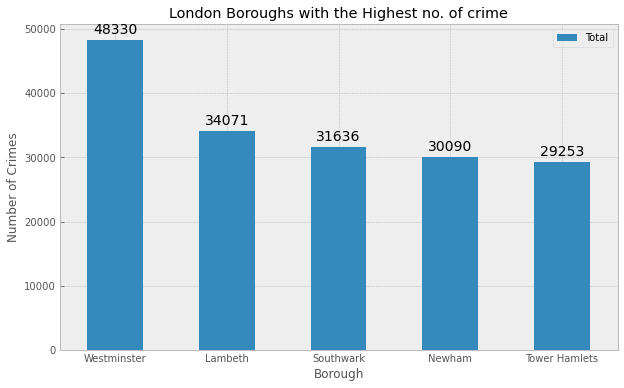

In [136]:
df_tt = df_top5[['Borough','Total']]

df_tt.set_index('Borough',inplace = True)

ax = df_tt.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Borough') # add y-label to the plot
ax.set_title('London Boroughs with the Highest no. of crime') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

#### Sort the total crimes in ascending order to see 5  boroughs with the highest number of crimes 

In [137]:
Ld_crime.sort_values(['Total'], ascending = True, axis = 0, inplace = True )

df_bot5 = Ld_crime.head() 
df_bot5

,Borough,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Population (2019 est)[1],Co-ordinates,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
6,City of London,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,9721.0,NaN,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,2,2,10,6,4,129,25,178
20,Kingston upon Thames,Kingston upon Thames London Borough Council,Liberal Democrat,"Guildhall, High Street",14.38,NaN,177507.0,51°24′31″N 0°18′23″W﻿ / ﻿51.4085°N 0.3064°W,879,1054,743,189,121,3803,3194,9983
28,Sutton,Sutton London Borough Council,Liberal Democrat,"Civic Offices, St Nicholas Way",16.93,NaN,206349.0,51°21′42″N 0°11′40″W﻿ / ﻿51.3618°N 0.1945°W,1233,1316,461,253,165,3516,3714,10658
26,Richmond upon Thames,Richmond upon Thames London Borough Council,Liberal Democrat,"Civic Centre, 44 York Street",22.17,NaN,198019.0,51°26′52″N 0°19′34″W﻿ / ﻿51.4479°N 0.3260°W,1359,1148,320,217,106,4769,3155,11074
23,Merton,Merton London Borough Council,Labour,"Civic Centre, London Road",14.52,NaN,206548.0,51°24′05″N 0°11′45″W﻿ / ﻿51.4014°N 0.1958°W,1419,1418,466,249,283,4894,4026,12755


#### Visualize the five boroughs with the least number of crimes 

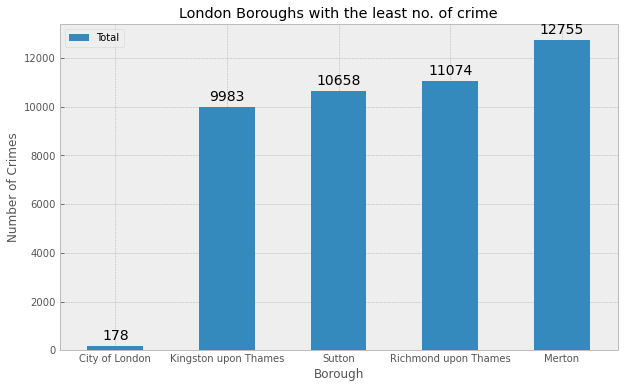

In [138]:
df_bt = df_bot5[['Borough','Total']]

df_bt.set_index('Borough',inplace = True)

ax = df_bt.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Borough') # add y-label to the plot
ax.set_title('London Boroughs with the least no. of crime') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

The borough City of London has the lowest no. of crimes recorded for the year 2016, Looking into the details of the borough: 

In [102]:
df_col = df_bot5[df_bot5['Borough'] == 'City of London']
df_col = df_col[['Borough','Total','Area (sq mi)','Population (2013 est)[1]']]
df_col

,Borough,Total,Area (sq mi),Population (2013 est)[1]
6,City of London,178,1.12,9721.0


#### As per the wikipedia page, The City of London is the 33rd principal division of Greater London but it is not a London borough. 
URL: https://en.wikipedia.org/wiki/List_of_London_boroughs

#### Hence we will focus on the next borough with the least crime i.e. Kingston upon Thames

### Visualizing different types of crimes in the borough 'Kingston upon Thames'

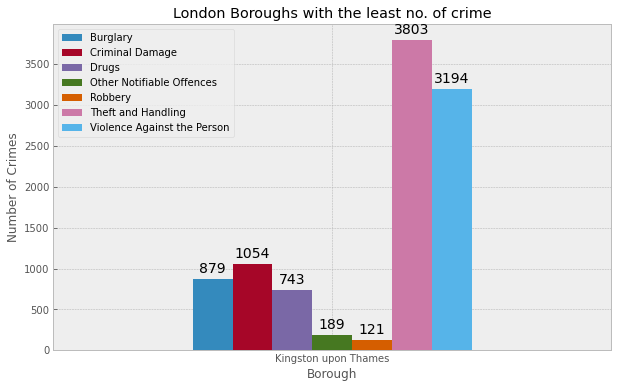

In [139]:
df_bc1 =  df_bot5[df_bot5['Borough'] == 'Kingston upon Thames']

df_bc = df_bc1[['Borough','Burglary','Criminal Damage','Drugs','Other Notifiable Offences',
                 'Robbery','Theft and Handling','Violence Against the Person']]


df_bc.set_index('Borough',inplace = True)

ax = df_bc.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Borough') # add y-label to the plot
ax.set_title('London Boroughs with the least no. of crime') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()


We can conclude that Kingston upon Thames is the safest borough when compared to the other boroughs in London. 

##### Third Dataset
https://en.wikipedia.org/wiki/List_of_districts_in_the_Royal_Borough_of_Kingston_upon_Thames

Creating a new dataset of the Neighborhoods of the safest borough in London and generating their co-ordinates.
This dataset was created from scratch using the list of neighborhood available on the wikipedia site. This dataset contains the following columns:
* Neighborhood: Name of the neighborhood in the Borough.
* Borough: Name of the Borough.
* Latitude: Latitude of the Borough.
* Longitude: Longitude of the Borough.

In [140]:
Neighborhood = ['Berrylands','Canbury','Chessington','Coombe','Hook','Kingston upon Thames',
'Kingston Vale','Malden Rushett','Motspur Park','New Malden','Norbiton',
'Old Malden','Seething Wells','Surbiton','Tolworth']

Borough = ['Kingston upon Thames','Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames']

Latitude = ['','','','','','','','','','','','','','','']
Longitude = ['','','','','','','','','','','','','','','']

df_neigh = {'Neighborhood': Neighborhood,'Borough':Borough,'Latitude': Latitude,'Longitude':Longitude}
kut_neig = pd.DataFrame(data=df_neigh, columns=['Neighborhood', 'Borough', 'Latitude', 'Longitude'], index=None)

kut_neig

,Neighborhood,Borough,Latitude,Longitude
0,Berrylands,Kingston upon Thames,,
1,Canbury,Kingston upon Thames,,
2,Chessington,Kingston upon Thames,,
3,Coombe,Kingston upon Thames,,
4,Hook,Kingston upon Thames,,
5,Kingston upon Thames,Kingston upon Thames,,
6,Kingston Vale,Kingston upon Thames,,
7,Malden Rushett,Kingston upon Thames,,
8,Motspur Park,Kingston upon Thames,,
9,New Malden,Kingston upon Thames,,


###### Finding the Co-ordiantes of each Neighborhood in the Kingston upon Thames Neighborhood

In [141]:
Latitude = []
Longitude = []

for i in range(len(Neighborhood)):
    address = '{},London,United Kingdom'.format(Neighborhood[i])
    geolocator = Nominatim(user_agent="London_agent")
    location = geolocator.geocode(address)
    Latitude.append(location.latitude)
    Longitude.append(location.longitude)
print(Latitude, Longitude)

[51.3990081, 51.423976749999994, 51.349514600000006, 51.3598192, 51.6420314, 51.4129277, 51.403073899999995, 51.3372558, 51.3948747, 51.4044333, 51.4136968, 51.3847246, 51.3934603, 51.3924111, 51.3768746] [-0.2809105, -0.27594079618025036, -0.31727279793885255, -0.0600802, -0.1703407, -0.3018577, -0.3032195937979538, -0.3202699, -0.2396076, -0.2539362, -0.2890233, -0.2612451, -0.3152559, -0.3039992, -0.2794424]


In [142]:
df_neigh = {'Neighborhood': Neighborhood,'Borough':Borough,'Latitude': Latitude,'Longitude':Longitude}
kut_neig = pd.DataFrame(data=df_neigh, columns=['Neighborhood', 'Borough', 'Latitude', 'Longitude'], index=None)

kut_neig

,Neighborhood,Borough,Latitude,Longitude
0,Berrylands,Kingston upon Thames,51.399008,-0.280911
1,Canbury,Kingston upon Thames,51.423977,-0.275941
2,Chessington,Kingston upon Thames,51.349515,-0.317273
3,Coombe,Kingston upon Thames,51.359819,-0.060080
4,Hook,Kingston upon Thames,51.642031,-0.170341
5,Kingston upon Thames,Kingston upon Thames,51.412928,-0.301858
6,Kingston Vale,Kingston upon Thames,51.403074,-0.303220
7,Malden Rushett,Kingston upon Thames,51.337256,-0.320270
8,Motspur Park,Kingston upon Thames,51.394875,-0.239608
9,New Malden,Kingston upon Thames,51.404433,-0.253936


###### Geting the co-ordinates of Berrylands, London, United Kingdom (The center neighborhood of Kingston upon Thames)

In [143]:
address = 'Berrylands, London, United Kingdom'

geolocator = Nominatim(user_agent="ld_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Berrylands, London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Berrylands, London are 51.3990081, -0.2809105.


###### Visualizing the Neighborhood of Kingston upon Thames Borough

In [144]:
# create map of New York using latitude and longitude values
map_lon = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(kut_neig['Latitude'], kut_neig['Longitude'], kut_neig['Borough'], kut_neig['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lon)  
    
map_lon

### Modelling <a name="modelling"></a>

- Finding all the venues within a 500 meter radius of each neighborhood.
- Perform one hot ecoding on the venues data.
- Grouping the venues by the neighborhood and calculating their mean.
- Performing a K-means clustering (Defining K = 5)

###### Creating a function to extract the venues from each Neighborhood

In [151]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            C_ID, 
            C_SEC, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [152]:
kut_venues = getNearbyVenues(names=kut_neig['Neighborhood'],
                                   latitudes=kut_neig['Latitude'],
                                   longitudes=kut_neig['Longitude']
                                  )


Berrylands
Canbury
Chessington
Coombe
Hook
Kingston upon Thames
Kingston Vale
Malden Rushett
Motspur Park
New Malden
Norbiton
Old Malden
Seething Wells
Surbiton
Tolworth


In [153]:
print(kut_venues.shape)
kut_venues.head()

(211, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berrylands,51.399008,-0.280911,The Berrylands Pub,51.398169,-0.280365,Pub
1,Berrylands,51.399008,-0.280911,The Walnut,51.398349,-0.280055,Coffee Shop
2,Berrylands,51.399008,-0.280911,Platform 1,51.398865,-0.280978,Platform
3,Berrylands,51.399008,-0.280911,Berrylands Railway Station (BRS),51.399081,-0.280913,Train Station
4,Berrylands,51.399008,-0.280911,Elmbridge Fields,51.395832,-0.276117,Park


In [147]:
kut_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berrylands,5,5,5,5,5,5
Canbury,4,4,4,4,4,4
Chessington,30,30,30,30,30,30
Coombe,4,4,4,4,4,4
Hook,4,4,4,4,4,4
Kingston Vale,12,12,12,12,12,12
Kingston upon Thames,30,30,30,30,30,30
Malden Rushett,2,2,2,2,2,2
Motspur Park,9,9,9,9,9,9


In [154]:
print('There are {} uniques categories.'.format(len(kut_venues['Venue Category'].unique())))

There are 79 uniques categories.


###### One hot encoding

URL: https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f

In [155]:
# one hot encoding
kut_onehot = pd.get_dummies(kut_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
kut_onehot['Neighborhood'] = kut_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [kut_onehot.columns[-1]] + list(kut_onehot.columns[:-1])
kut_onehot = kut_onehot[fixed_columns]

kut_onehot.head()

,Neighborhood,Aquarium,Arts & Crafts Store,Athletics & Sports,Auto Garage,Bakery,Bar,Bistro,Bookstore,Bowling Alley,...,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Train Station,Tram Station,Turkish Restaurant,Zoo Exhibit
0,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


###### Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [156]:
kut_grouped = kut_onehot.groupby('Neighborhood').mean().reset_index()
kut_grouped

,Neighborhood,Aquarium,Arts & Crafts Store,Athletics & Sports,Auto Garage,Bakery,Bar,Bistro,Bookstore,Bowling Alley,...,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Train Station,Tram Station,Turkish Restaurant,Zoo Exhibit
0,Berrylands,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.00,0.000000,0.000000
1,Canbury,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
2,Chessington,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.033333,0.033333,0.466667,0.000000,0.00,0.000000,0.133333
3,Coombe,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.25,0.000000,0.000000
4,Hook,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
5,Kingston Vale,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
6,Kingston upon Thames,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,...,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.00,0.033333,0.000000
7,Malden Rushett,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
8,Motspur Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.00,0.000000,0.000000
9,New Malden,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000


In [157]:
kut_grouped.shape

(15, 80)

In [158]:
num_top_venues = 5

for hood in kut_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = kut_grouped[kut_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berrylands----
           venue  freq
0           Park   0.2
1            Pub   0.2
2       Platform   0.2
3  Train Station   0.2
4    Coffee Shop   0.2


----Canbury----
                 venue  freq
0                 Park  0.33
1             Bus Stop  0.33
2                Hotel  0.33
3  Japanese Restaurant  0.00
4          Karaoke Bar  0.00


----Chessington----
                          venue  freq
0  Theme Park Ride / Attraction  0.47
1                   Zoo Exhibit  0.13
2                         Hotel  0.10
3                   Coffee Shop  0.03
4                    Theme Park  0.03


----Coombe----
                   venue  freq
0           Tram Station  0.25
1         Scenic Lookout  0.25
2  Performing Arts Venue  0.25
3     Chinese Restaurant  0.25
4               Aquarium  0.00


----Hook----
               venue  freq
0  Fish & Chips Shop   0.2
1                Pub   0.2
2     Massage Studio   0.2
3        Coffee Shop   0.2
4      Grocery Store   0.2


----Kingston Vale--

###### Create a data frame of the venues 
Function to sort the venues in descending order.

In [159]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create the new dataframe and display the top 10 venues for each neighborhood

In [160]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = kut_grouped['Neighborhood']

for ind in np.arange(kut_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(kut_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berrylands,Pub,Train Station,Coffee Shop,Park,Platform,Forest,Discount Store,Electronics Store,Farmers Market,Fast Food Restaurant
1,Canbury,Hotel,Park,Bus Stop,Zoo Exhibit,Fried Chicken Joint,Fast Food Restaurant,Fish & Chips Shop,Food,Forest,French Restaurant
2,Chessington,Theme Park Ride / Attraction,Zoo Exhibit,Hotel,Restaurant,Coffee Shop,Forest,Fried Chicken Joint,Gift Shop,Mexican Restaurant,Aquarium
3,Coombe,Tram Station,Performing Arts Venue,Chinese Restaurant,Scenic Lookout,Zoo Exhibit,French Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Food
4,Hook,Grocery Store,Coffee Shop,Fish & Chips Shop,Massage Studio,Pub,Zoo Exhibit,French Restaurant,Farmers Market,Fast Food Restaurant,Food


#### Clustering similar neighborhoods together by using kmeans clustering

In [161]:
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

kut_grouped_clustering = kut_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(kut_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 2, 4, 3, 0, 0, 0, 1, 0, 0], dtype=int32)

In [120]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

kut_merged = kut_neig

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
kut_merged = kut_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

kut_merged.head() # check the last columns!

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berrylands,Kingston upon Thames,51.399008,-0.280911,2,Platform,Train Station,Coffee Shop,Park,Pub,Zoo Exhibit,Fried Chicken Joint,Fast Food Restaurant,Fish & Chips Shop,Food
1,Canbury,Kingston upon Thames,51.423977,-0.275941,4,Hotel,Park,Garden,Bus Stop,Gym Pool,Gym / Fitness Center,Fish & Chips Shop,Food,Forest,French Restaurant
2,Chessington,Kingston upon Thames,51.349515,-0.317273,1,Theme Park Ride / Attraction,Zoo Exhibit,Playground,Hotel,Aquarium,Forest,Theme Park,Theater,BBQ Joint,Zoo
3,Coombe,Kingston upon Thames,51.359819,-0.060080,3,Tram Station,Performing Arts Venue,Scenic Lookout,Chinese Restaurant,Zoo Exhibit,Garden,Fish & Chips Shop,Food,Forest,French Restaurant
4,Hook,Kingston upon Thames,51.642031,-0.170341,0,Pub,Fish & Chips Shop,Grocery Store,Coffee Shop,Garden,Fast Food Restaurant,Food,Forest,French Restaurant,Fried Chicken Joint


In [162]:
kut_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15 entries, 0 to 14
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Neighborhood            15 non-null     object 
 1   Borough                 15 non-null     object 
 2   Latitude                15 non-null     float64
 3   Longitude               15 non-null     float64
 4   Cluster Labels          15 non-null     int64  
 5   1st Most Common Venue   15 non-null     object 
 6   2nd Most Common Venue   15 non-null     object 
 7   3rd Most Common Venue   15 non-null     object 
 8   4th Most Common Venue   15 non-null     object 
 9   5th Most Common Venue   15 non-null     object 
 10  6th Most Common Venue   15 non-null     object 
 11  7th Most Common Venue   15 non-null     object 
 12  8th Most Common Venue   15 non-null     object 
 13  9th Most Common Venue   15 non-null     object 
 14  10th Most Common Venue  15 non-null     obje

In [122]:
# Dropping the row with the NaN value 
kut_merged.dropna(inplace = True)

In [163]:
kut_merged.shape

(15, 15)

In [164]:
kut_merged['Cluster Labels'] = kut_merged['Cluster Labels'].astype(int)

In [165]:
kut_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15 entries, 0 to 14
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Neighborhood            15 non-null     object 
 1   Borough                 15 non-null     object 
 2   Latitude                15 non-null     float64
 3   Longitude               15 non-null     float64
 4   Cluster Labels          15 non-null     int64  
 5   1st Most Common Venue   15 non-null     object 
 6   2nd Most Common Venue   15 non-null     object 
 7   3rd Most Common Venue   15 non-null     object 
 8   4th Most Common Venue   15 non-null     object 
 9   5th Most Common Venue   15 non-null     object 
 10  6th Most Common Venue   15 non-null     object 
 11  7th Most Common Venue   15 non-null     object 
 12  8th Most Common Venue   15 non-null     object 
 13  9th Most Common Venue   15 non-null     object 
 14  10th Most Common Venue  15 non-null     obje

### Visualize the clusters

In [166]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kut_merged['Latitude'], kut_merged['Longitude'], kut_merged['Neighborhood'], kut_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

Each cluster is color coded for the ease of presentation, we can see that majority of the neighborhood falls in the red cluster which is the first cluster. Three neighborhoods have their own cluster (Blue, Purple and Yellow), these are clusters two three and five. The green cluster consists of two neighborhoods which is the 4th cluster. 

## Analysis <a name="analysis"></a>

Analyse each of the clusters to identify the characteristics of each cluster and the neighborhoods in them.

#### Examine the first cluster

In [167]:
kut_merged[kut_merged['Cluster Labels'] == 0]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Hook,Kingston upon Thames,51.642031,-0.170341,0,Pub,Fish & Chips Shop,Grocery Store,Coffee Shop,Garden,Fast Food Restaurant,Food,Forest,French Restaurant,Fried Chicken Joint
7,Malden Rushett,Kingston upon Thames,51.337256,-0.320270,0,Pub,Grocery Store,Garden Center,Fast Food Restaurant,Fish & Chips Shop,Food,Forest,French Restaurant,Fried Chicken Joint,Furniture / Home Store


The most common venues in these neighborhoods are Restaurants, Pubs, Cafe, Supermarkets,  and stores.

#### Examine the second cluster

In [168]:
kut_merged[kut_merged['Cluster Labels'] == 1]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Chessington,Kingston upon Thames,51.349515,-0.317273,1,Theme Park Ride / Attraction,Zoo Exhibit,Playground,Hotel,Aquarium,Forest,Theme Park,Theater,BBQ Joint,Zoo
5,Kingston upon Thames,Kingston upon Thames,51.412928,-0.301858,1,Coffee Shop,Sushi Restaurant,Hotel,Clothing Store,Record Shop,Public Art,Pub,Department Store,Electronics Store,Pedestrian Plaza
9,New Malden,Kingston upon Thames,51.404433,-0.253936,1,Korean Restaurant,Coffee Shop,Supermarket,Café,Gym / Fitness Center,Japanese Restaurant,Fast Food Restaurant,Office,Newsagent,Department Store
10,Norbiton,Kingston upon Thames,51.413697,-0.289023,1,Pub,Italian Restaurant,Indian Restaurant,Food,Hardware Store,Pizza Place,Gastropub,Grocery Store,Japanese Restaurant,Tapas Restaurant
12,Seething Wells,Kingston upon Thames,51.393460,-0.315256,1,Pub,Indian Restaurant,Café,Harbor / Marina,Fast Food Restaurant,Restaurant,Park,Coffee Shop,Chinese Restaurant,Fish & Chips Shop
13,Surbiton,Kingston upon Thames,51.392411,-0.303999,1,Coffee Shop,Pub,Grocery Store,Café,Indian Restaurant,Italian Restaurant,Gastropub,French Restaurant,Fish & Chips Shop,Farmers Market
14,Tolworth,Kingston upon Thames,51.376875,-0.279442,1,Hotel,Bowling Alley,Coffee Shop,Sandwich Place,Furniture / Home Store,Soccer Field,Pizza Place,Garden Center,Bus Stop,Grocery Store


The second cluster has seven neighborhood which consists of Venues such as Restaurants, Pub, Hotel,Zoo and park.  

#### Examine the third cluster

In [169]:
kut_merged[kut_merged['Cluster Labels'] == 2]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berrylands,Kingston upon Thames,51.399008,-0.280911,2,Platform,Train Station,Coffee Shop,Park,Pub,Zoo Exhibit,Fried Chicken Joint,Fast Food Restaurant,Fish & Chips Shop,Food
8,Motspur Park,Kingston upon Thames,51.394875,-0.239608,2,Park,Pub,Indian Restaurant,Cosmetics Shop,Rugby Pitch,Soccer Field,Mediterranean Restaurant,Train Station,Golf Course,Grocery Store
11,Old Malden,Kingston upon Thames,51.384725,-0.261245,2,Food,Train Station,Construction & Landscaping,Park,Zoo Exhibit,Garden,Fish & Chips Shop,Forest,French Restaurant,Fried Chicken Joint


The third cluster has three neighborhood which consists of Venues such as Train stations, Restaurants, Zoo, Park.  

#### Examine the forth cluster

In [170]:
kut_merged[kut_merged['Cluster Labels'] == 3]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Coombe,Kingston upon Thames,51.359819,-0.06008,3,Tram Station,Performing Arts Venue,Scenic Lookout,Chinese Restaurant,Zoo Exhibit,Garden,Fish & Chips Shop,Food,Forest,French Restaurant


The fourth cluster has one neighborhoods in it, this neighborhood has common venues such as Tram Station, Performing Arts Venue, Scenic Lookout, Chinese Restaurant, Zoo Exhibit and Garden.

#### Examine the fifth cluster

In [171]:
kut_merged[kut_merged['Cluster Labels'] == 4]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Canbury,Kingston upon Thames,51.423977,-0.275941,4,Hotel,Park,Garden,Bus Stop,Gym Pool,Gym / Fitness Center,Fish & Chips Shop,Food,Forest,French Restaurant
6,Kingston Vale,Kingston upon Thames,51.403074,-0.303220,4,Park,Grocery Store,Pub,Hotel,Breakfast Spot,Café,Burger Joint,Hookah Bar,Bowling Alley,Bookstore


The fifth cluster has two neighborhoods which consist of Venues such as Hotel, park, Garden, Gym and Pub.

## Results and Discussion <a name="results"></a>

This project's goal is helping people who want to relocate to the safest borough in London, expats can chose the neighborhoods to which they want to relocate based on the most common venues in it. For example if a person is looking for a neighborhood with good connectivity and public transportation we can see that Clusters 3 and 4 have Train stations and Bus stops as the most common venues. If a person is looking for a neighborhood with stores and restaurants in a close proximity then the neighborhoods in the first cluster is suitable. For a family I feel that the neighborhoods in Cluster 4 are more suitable dues to the common venues in that cluster, these neighborhoods have common venues such as Parks, Gym/Fitness centers, Bus Stops, Restaurants, Electronics Stores and Soccer fields which is ideal for a family. 

## Conclusion <a name="conclusion"></a>

This project helps a person get a better understanding of the neighborhoods with respect to the most common venues in that neighborhood. It is always helpful to make use of technology to stay one step ahead i.e. finding out more about places before moving into a neighborhood. We have just taken safety as a primary concern to shortlist the borough of London. The future of this project includes taking other factors such as cost of living in the areas into consideration to shortlist the borough based on safety and a predefined budget.  